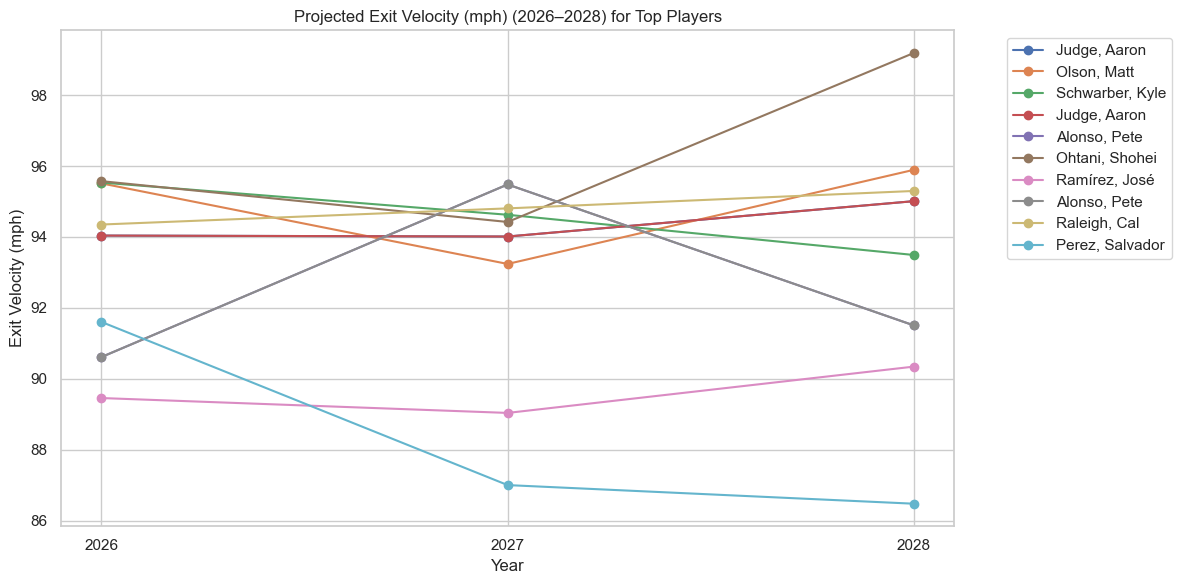

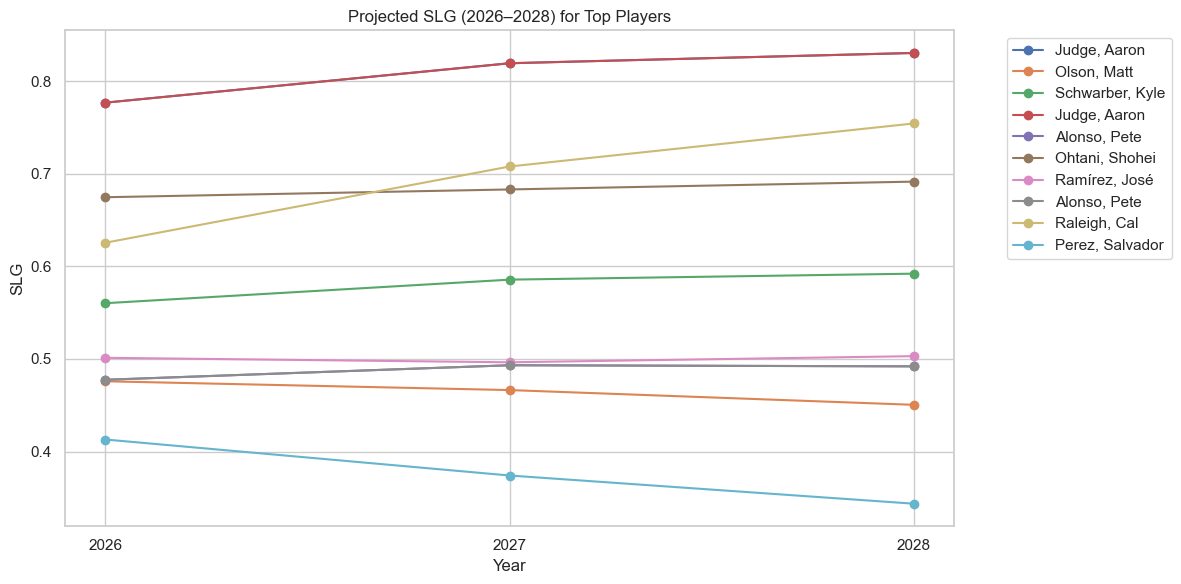

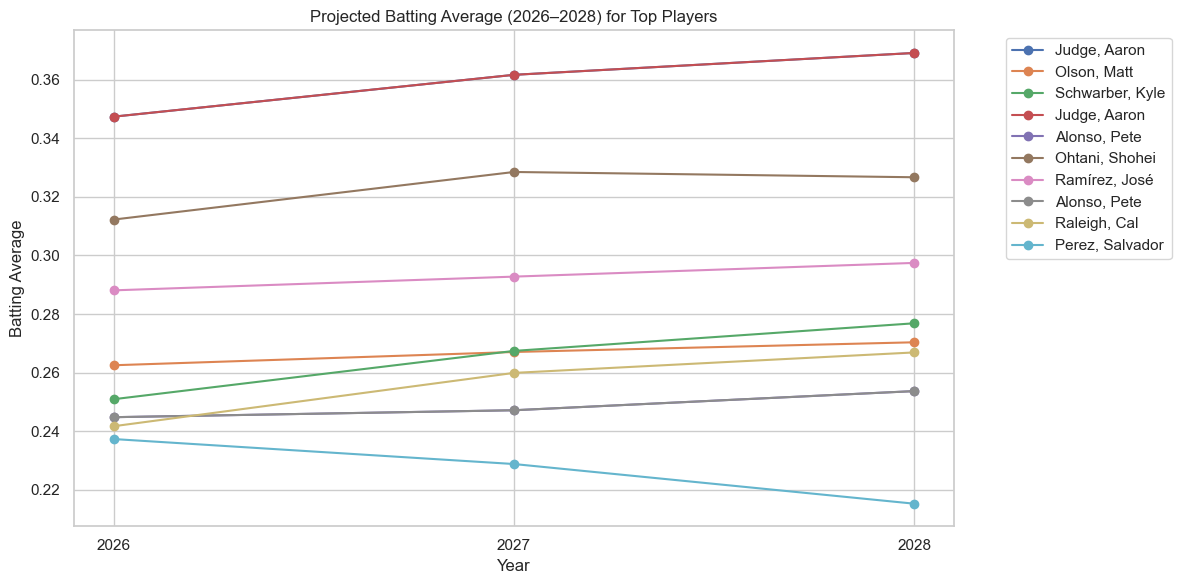

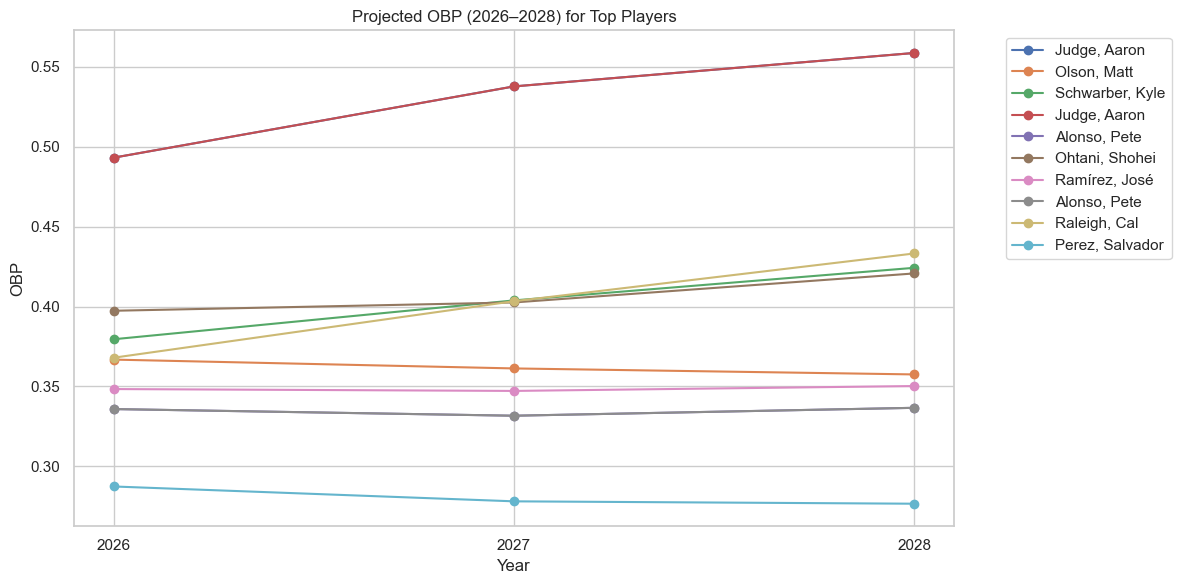

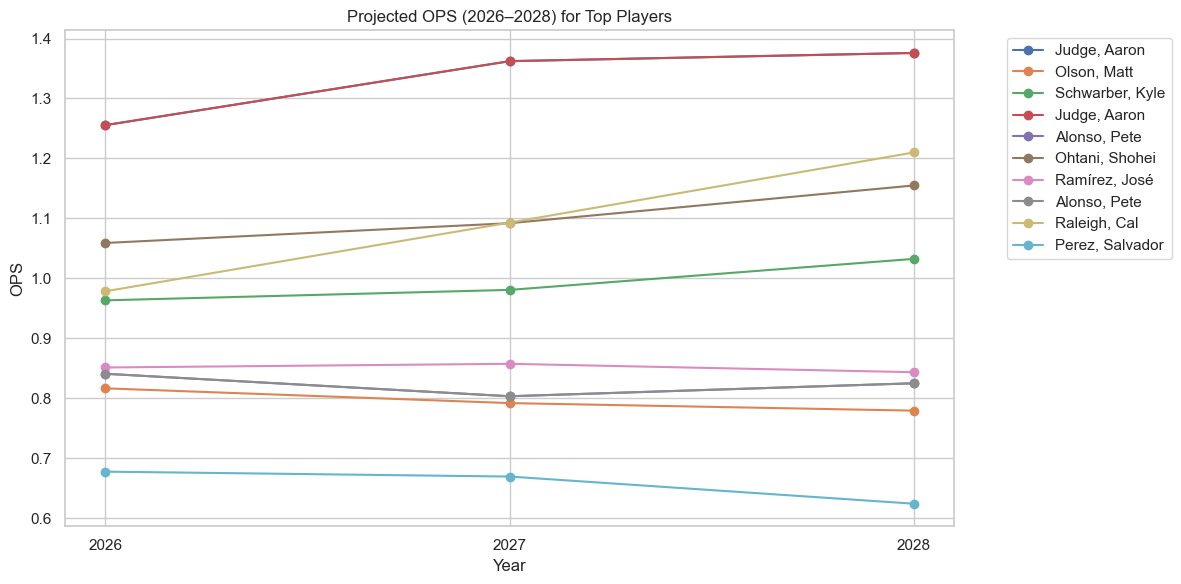

In [5]:
# ==============================
# MLB Player Projection 2026–2028
# ==============================

import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# ---- CONFIG ----
FILE_PATH = "../data/MLB player stats 2021-2025.csv"
OUTPUT_FOLDER = "../output"
YEARS_PROJ = [2026, 2027, 2028]

# Ensure output folder exists
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# ---- READ DATA ----
df = pd.read_csv(FILE_PATH)

# ---- KPI CORRELATIONS (from heatmap) ----
kpi_predictors = {
    'exit_velocity_avg': ['isolated_power', 'slg_percent'],
    'slg_percent': ['on_base_plus_slg', 'isolated_power'],
    'batting_avg': ['on_base_plus_slg'],
    'on_base_percent': ['on_base_plus_slg'],
    'b_rbi': ['slg_percent', 'isolated_power'],
    'isolated_power': ['slg_percent', 'on_base_plus_slg'],
    'on_base_plus_slg': ['slg_percent', 'isolated_power', 'on_base_percent']
}

# Mapping for professional plot labels
display_names = {
    'exit_velocity_avg': 'Exit Velocity (mph)',
    'slg_percent': 'SLG',
    'batting_avg': 'Batting Average',
    'on_base_percent': 'OBP',
    'b_rbi': 'RBI',
    'isolated_power': 'ISO',
    'on_base_plus_slg': 'OPS'
}

# ---- PROJECTION FUNCTION ----
def project_kpi(df, kpi, predictors):
    proj_dict = {}
    for player in df['last_name, first_name']:
        y_hist = df.loc[df['last_name, first_name']==player, kpi].values
        if len(y_hist) == 0:
            y_hist = [0]*5  # fallback
        X_years = np.arange(len(y_hist)).reshape(-1, 1)
        model = LinearRegression()
        model.fit(X_years, y_hist)
        proj_values = model.predict(np.arange(len(y_hist), len(y_hist)+len(YEARS_PROJ)).reshape(-1,1))

        # Small variation based on predictors
        if len(predictors) > 0:
            pred_means = df.loc[df['last_name, first_name']==player, predictors].mean().values
            variation = (pred_means.mean() / max(pred_means.mean(), 1e-6)) * np.random.uniform(-0.03, 0.03, len(YEARS_PROJ))
            proj_values = proj_values * (1 + variation)

        proj_dict[player] = proj_values

    proj_df = pd.DataFrame(proj_dict, index=YEARS_PROJ)
    return proj_df

# ---- Generate projections ----
proj_dfs = {}
for kpi, predictors in kpi_predictors.items():
    proj_dfs[kpi] = project_kpi(df, kpi, predictors)

# ---- Save projection CSVs and PNGs to OUTPUT_FOLDER ----
sns.set(style="whitegrid")
top_players = df.sort_values('b_rbi', ascending=False)['last_name, first_name'].head(10).tolist()

for kpi, proj in proj_dfs.items():
    # Save CSV
    proj.to_csv(os.path.join(OUTPUT_FOLDER, f"MLB_player_projection_{display_names[kpi]}_2026_2028.csv"))

    # Plot top players
    plt.figure(figsize=(12,6))
    for player in top_players:
        plt.plot(proj.index, proj[player], marker='o', label=player)
    plt.title(f"Projected {display_names[kpi]} (2026–2028) for Top Players")
    plt.xlabel("Year")
    plt.ylabel(display_names[kpi])
    plt.xticks(proj.index)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    # Save PNG
    plt.savefig(os.path.join(OUTPUT_FOLDER, f"MLB_player_projection_{display_names[kpi]}_2026_2028.png"))
    plt.show()